# Model 4: Stacked LSTM
    - 2 LSTM layers

## Preprocess data

In [1]:
#Imports 
import numpy as np
import os
import shutil
import fnmatch

from collections import OrderedDict
from nltk import word_tokenize

data_path='/home/ubuntu/data/training/keras/aclImdb/'



# Generator of list of files in a folder and subfolders
def gen_find(filepath,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepath):
            yield os.path.join(path,name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

def tokenize(sentences):
    print 'Tokenizing...',
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence.decode('utf-8'))]
    print('Done!')
    return tokens

def build_dict(sentences):
    print 'Building dictionary..',
    wordcount = dict()
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = wordcount.values()
    keys = wordcount.keys()
    sorted_idx = np.argsort(counts)[::-1]

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+2  # leave 0 and 1 (UNK)
    print np.sum(counts), ' total words ', len(keys), ' unique words'
    return worddict, wordcount

def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs

#Data extraction

#Extract training sentences
sentences_trn_pos = tokenize(read_sentences(data_path+'train/pos/'))
sentences_trn_neg = tokenize(read_sentences(data_path+'train/neg/'))
sentences_trn = sentences_trn_pos + sentences_trn_neg

#Build train dictionary
worddict, wordcount = build_dict(sentences_trn)

#Generate train data
train_x_pos = generate_sequence(sentences_trn_pos, worddict)
train_x_neg = generate_sequence(sentences_trn_neg, worddict)
X_train_full = train_x_pos + train_x_neg
y_train_full = [1] * len(train_x_pos) + [0] * len(train_x_neg)


#Read test sentences and generate target y
sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

test_x_pos = generate_sequence(tokenize(sentences_tst_pos), worddict)
test_x_neg = generate_sequence(tokenize(sentences_tst_neg), worddict)
X_test_full = test_x_pos + test_x_neg
y_test_full = [1] * len(test_x_pos) + [0] * len(test_x_neg)


print('Preprocess done!')

Tokenizing... Done!
Tokenizing... Done!
Building dictionary.. 7056193  total words  135098  unique words
Tokenizing... Done!
Tokenizing... Done!
Preprocess done!


## Prepare sequences to model


In [2]:
max_features = 20000 # Number of most frequent words selected. the less frequent recode to 0
max_len = 100  # cut texts after this number of words (among top max_features most common words)


#Select the most frequent max_features, recode others using 0
def remove_features(x):
    return [[0 if w >= max_features else w for w in sen] for sen in x]

X_train = remove_features(X_train_full)
X_test  = remove_features(X_test_full)
y_train = y_train_full
y_test = y_test_full


# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)


# Cut or complete the sentences to length = maxlen
from keras.preprocessing import sequence

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


Using Theano backend.
Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Pad sequences (samples x time)
('X_train shape:', (25000, 100))
('X_test shape:', (25000, 100))


## Build model

In [14]:
# Model
dim_embedings = 128 #Dimension of the embedings vector
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense, merge
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, ), dtype='int32') 

# LAYER 2: Create embedings
embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
droput_percent = 0.3
forwards1 = LSTM(num_hidden_rnn, return_sequences=True,
                 dropout_W=droput_percent, dropout_U=droput_percent, name='Forward 1')(embeds)
rnn_out = LSTM(num_hidden_rnn, return_sequences=False,
                 dropout_W=droput_percent, dropout_U=droput_percent, name='Forward 2')(forwards1)


# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(input=seq_prev_input, output=output)
model_1.summary()

# Compile model and select optimizer
rms_optimizer = RMSprop(lr=0.001)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=rms_optimizer, metrics=['accuracy'])



Build model 1 - Basic model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 100, 128)      2560000     input_5[0][0]                    
____________________________________________________________________________________________________
Forward 1 (LSTM)                 (None, 100, 128)      131584      embedding_5[0][0]                
____________________________________________________________________________________________________
Forward 2 (LSTM)                 (None, 128)           131584      Forward 1[0][0]                  
____________________________________________________________

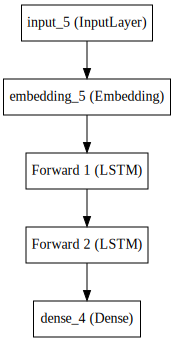

In [15]:
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

In [16]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 166s - loss: 0.6990 - acc: 0.5146 - val_loss: 0.6864 - val_acc: 0.5031
Epoch 2/10
25000/25000 [==============================] - 174s - loss: 0.5276 - acc: 0.7339 - val_loss: 0.4105 - val_acc: 0.8157
Epoch 3/10
25000/25000 [==============================] - 175s - loss: 0.3829 - acc: 0.8335 - val_loss: 0.3902 - val_acc: 0.8308
Epoch 4/10
25000/25000 [==============================] - 175s - loss: 0.3209 - acc: 0.8682 - val_loss: 0.4558 - val_acc: 0.8374
Epoch 5/10
25000/25000 [==============================] - 121s - loss: 0.2876 - acc: 0.8865 - val_loss: 0.4839 - val_acc: 0.8182
Epoch 6/10
25000/25000 [==============================] - 92s - loss: 0.2553 - acc: 0.9006 - val_loss: 0.4270 - val_acc: 0.8326
Epoch 7/10
25000/25000 [==============================] - 92s - loss: 0.2280 - acc: 0.9100 - val_loss: 0.4153 - val_acc: 0.8310
Epoch 8/10
25000/25000 [================

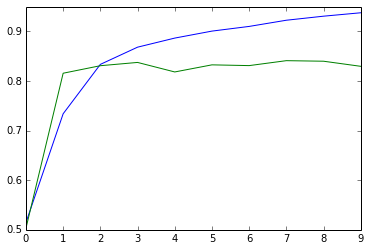

In [17]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [18]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


0.8296
AUC:  0.9147284544


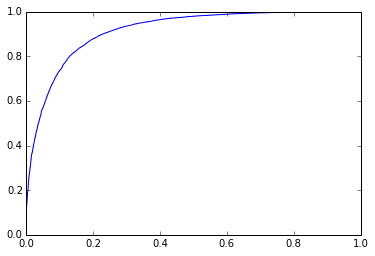

In [19]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline
#Calculate accuracy with sklearn
print(accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print 'AUC: ', auc(fpr, tpr)  

#Plot ROC curve
plt.plot(fpr, tpr)

In [20]:
#Evaluate one positive record
i = 1 # 1, 2, ... , 25000
print('Sentence: ',sentences_tst_pos[i])
print('target: ',y_test_full[i])
print('Prediction [neg, pos]: ', pred_test[i])

('Sentence: ', "This short was the first short released by Paramount Famous Studios and was one of several done by the studio showing Popeye engaged directly against the enemy, most often the Japanese. While Warner Brothers, Disney and, to a lesser extent, other studios, did shorts often depicting Germans as foils, the majority of Famous Studios efforts focused on the Japanese. Given Pearl Harbor and Popeye's naval ties, this is quite understandable. This is an average short. Seein' Red, White an' Blue and Spinach For Britain have aged better. But it's still worth watching. Recommended.")
('target: ', 1)
('Prediction [neg, pos]: ', array([ 0.00145513,  0.99854493]))


In [21]:
#Evaluate one negative record
i = -2 # -2, -3, ... -25000
print('Sentence: ',sentences_tst_neg[i])
print('target: ',y_test[i])
print('Prediction [neg, pos]: ', pred_test[i])

('Sentence: ', "You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the

In [22]:
# Score new text
def score_new_text(text):
    seq = generate_sequence(tokenize([text]), worddict)
    seq = remove_features(seq)
    seq = sequence.pad_sequences(seq, maxlen=max_len)
    pred_test = model_1.predict(seq, batch_size=1)
    return float(pred_test[:,1])


text = "You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the full movie like i did."
print('Positive score:', score_new_text(text))

Tokenizing... Done!
('Positive score:', 0.04356706514954567)
